# The Wilson-Cowan model

In this notebook, the basic use of the implementation of the Wilson-Cowan (`wc`) model is presented. 

In the `wc` model, the activity of a particular brain region is defined by a coupled system of excitatory (E) and inhibitory (I) neuronal populations with the mean firing rates of the E and I pools being the dynamic variables, as first described by Wilson and Cowan in 1972 ( H.R. Wilson and J.D. Cowan. *Excitatory and inhibitory interactions in localized populations of model neurons*. Biophys. J., 12:1–24 (1972)) 

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
# get the current directory
cwd = os.getcwd()


# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: /Users/masha/Documents/Uni/Thesis/neurolib


In [2]:
from neurolib.models.wc import WCModel
# Some useful functions are provided here
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim
import numpy as np
import scipy

In [3]:
import math

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from neurolib.models.wc import WCModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [6]:
wc = WCModel()
wc.params['duration'] = 2.0*1000

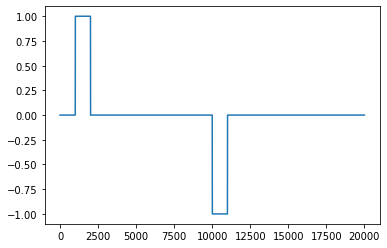

In [7]:
stimulus = np.zeros((1,20000))
stimulus[0][1000:2000] = 1
stimulus[0][10000:11000] = -1
plt.plot(stimulus.T)



In [8]:
stimulus = stim.StepInput(step_size=0.001,  start=5, end=100, n=1).to_model(wc)


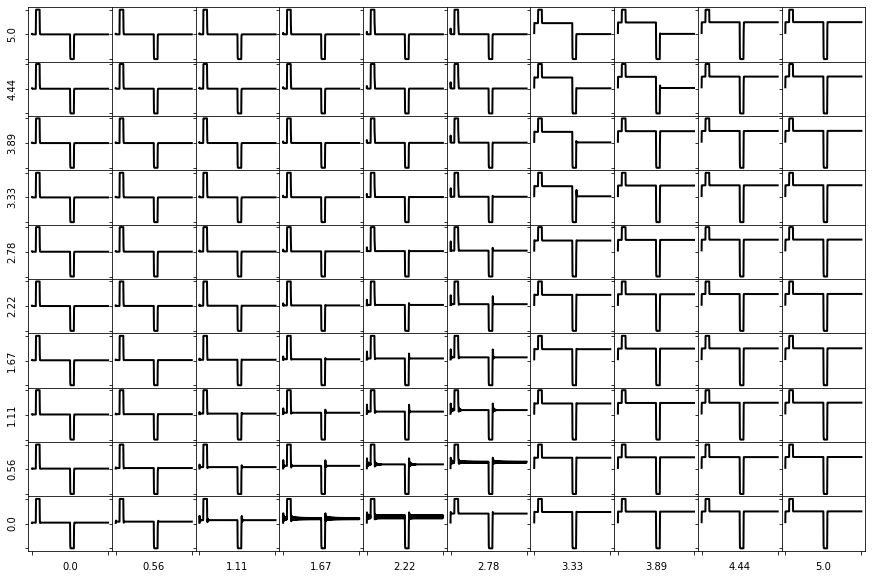

In [61]:
max_exc = []
min_exc = []
ex = []
wc = WCModel()
wc.params['duration'] = 2.0*1000
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1
#wc.params["control_term_E"] = stimulus
# these are the different input values that we want to scan
exc_inputs_n = 10
inh_inputs_n = 10
exc_inputs = np.linspace(0, 5, exc_inputs_n)
inh_inputs = np.linspace(0, 5, inh_inputs_n)
fig,a =  plt.subplots(inh_inputs_n,exc_inputs_n,  sharex='col', sharey='row', figsize=(15,10))
for i, inh_ext in enumerate(inh_inputs):
    for j, exc_ext in enumerate(exc_inputs):
        # Note: this has to be a vector since it is input for all nodes
        # (but we have only one node in this example)
        wc.params['exc_ext'] = exc_ext
        wc.params['inh_ext'] = inh_ext
        wc.params["control_term_E"] = stimulus
        #wc.params["control_term_I"] = stimulus
        wc.run()
        # we add the maximum and the minimum of the last second of the 
        # simulation to a list
        max_exc.append(np.max(wc.exc[0, -int(1000/wc.params['dt']):]))
        min_exc.append(np.min(wc.exc[0, -int(1000/wc.params['dt']):]))
        #print(np.shape(wc.exc))
        ex = wc.exc


        #plt.figure(figsize = (20, 6))
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()
        
        
        #fig, ax = plt.subplots(50, 50, sharex='col', sharey='row')

        #ax[i, j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        
        
        
        a[inh_inputs_n-i-1][j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #a[9-i][j].plot(s)

        # Turn off tick labels
        a[inh_inputs_n-i-1][j].set_yticklabels([])
        a[inh_inputs_n-i-1][j].set_xticklabels([])
        
        if(i==0):
            a[inh_inputs_n-i-1][j].set_xlabel(round(exc_ext, 2))
        if(j==0):
            a[inh_inputs_n-i-1][j].set_ylabel(round(inh_ext, 2))
       

        #plt.show()

        #ex = wc.inh
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()

        #print(np.shape(wc.bracets))
        #plt.plot(wc.params['duration']/wc.params['dt'], wc.exc[0], c='k', lw = 2)
        #plt.show()

plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)
#fig.tight_layout()
plt.show()

In [334]:
def optimal_control(wc, exc_exp, inh_exp, n_iter = 5000, plot_freq = 200, w = [0,0], a = 0, b = 0, debug = False):
    
    #h = (xn-x0)/n_step
    #times = np.arange(0, xn+h, h)
    times = range(int(wc.params['duration']/wc.params['dt']))
    #print(times)
    u_i = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #print("u_i", u_i)
    u_e = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #u_i = stimulus
    #u_e = stimulus

    for l in range(n_iter):

        wc.params["control_term_E"] = u_e
        wc.params["control_term_I"] = u_i

        
        wc.run()
        #print("check", wc.brackets_E)
        ex = wc.exc
        inh = wc.inh
        
        if(debug):
            print(np.shape(ex))
            print(int(wc.params['duration']/wc.params['dt']))
        if (l%plot_freq==0):
            print("iteration:", l)
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, exc_exp.T, c = 'blue',label="exc_target")
            plt.plot(wc.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(wc.t, u_e.T, c='r', lw = 2,label="stimulus")
            plt.legend()
            plt.show()
        
        
        lambdas = euler_backwards(wc, exc_exp, inh_exp, wc.params['dt'], int(math.ceil(wc.params['duration']/wc.params['dt'])), a, debug)
        if debug:
            print("lambdas", lambdas)
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, [x[0] for x in lambdas], c='blue', lw = 2, label="lambdas")
            plt.legend()
            plt.show()
        
        #w = [0,0]
        
        grad = grad_f(w, u_e,u_i, lambdas, times, a)
        if debug:
            print("grad", grad)

            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, np.array(grad[0]), c='red', lw = 2, label="grad")
            plt.legend()
            plt.show()
        
        step_size_adj = 10 #0.005
        
        
        step_size_adj = bisection(wc, step_size_adj,u_e,u_i,grad, times, exc_exp, w, debug, b)
        #if(l == 0):
        #    step_size_adj = 0.1
            
        if debug:
            print("step", step_size_adj)
            print("step_new", step_size_adj*np.array(grad[0]))

        u_e = u_e-step_size_adj*np.array(grad[0])
        u_i = u_i-step_size_adj*np.array(grad[1])

            
            

In [329]:
def bisection(model, step_size, u_e, u_i, grad, times, exc_exp, w, debug = False, b = 0):
    cost_temp = 10**12
    while step_size > 0.000001:

        u_e_1 = u_e-step_size*np.array(grad[0])
        u_i_1 = u_i-step_size*np.array(grad[1])

        model.params["control_term_E"] = u_e_1
        model.params["control_term_I"] = u_i_1


        wc.run()
        ex = model.exc
        inh = model.inh
        
        if debug:
            plt.figure(figsize = (8, 5))
            plt.plot(model.t, exc_exp.T,c = 'blue', label="exc_target")
            plt.plot(model.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(model.t, u_e_1.T, c='r', lw = 2, label="stimulus")
            plt.legend()
            plt.show()

        cost = cost_f(w, ex[0], exc_exp, u_e_1, u_i_1, times, b)
        if debug:
            print("cost", cost)
            print("step_size", step_size)
        #step_size = step_size/2
        #cost_temp = cost
        if(cost<cost_temp):
            step_size = step_size/2
            cost_temp = cost
        else:
            return step_size
        
    return 0
        

def cost_f(w, x, x_, u_exc, u_inh, times, b = 0):
    #b = 0
    #return np.sum(1/2*(x_-x)**2) 
    x_new = x[b:]
    x_new_ = x_[b:]
    times_new = times[b:]
    return scipy.integrate.simps(1/2*(x_new_-x_new)**2,times_new) \
            + w[0] * ((np.sqrt(scipy.integrate.simps(u_exc**2, times))) \
             + np.sqrt(scipy.integrate.simps(u_inh**2, times))) \
                + w[1] * 0.5*(scipy.integrate.simps(u_inh**2 + u_exc**2, times))
    #return  0.3 * (np.sqrt(scipy.integrate.simps(u_exc**2, times)) \
    #        + np.sqrt(scipy.integrate.simps(u_inh**2, times)) \
    #        + 0.5 * scipy.integrate.simps(u_exc**2 + u_inh**2, times)) \
    #        + scipy.integrate.simps((x-x_)**2,times)

In [330]:
def S_E(x, model):
    a_exc = model.params["a_exc"]
    mu_exc = model.params["mu_exc"]
    return 1.0 / (1.0 + np.exp(-a_exc * (x - mu_exc)))
    #return 1.0/(np.exp(-a_exc*(x-mu_exc))+1.0)
    

def S_I(x, model):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    #return 1.0/(np.exp(-a_inh*(x-mu_inh))+1.0)
    return 1.0 / (1.0 + np.exp(-a_inh * (x - mu_inh)))

def dh1_dE(model, i):
    a_exc = model.params["a_exc"]
    C_EE = model.params["c_excexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]

    return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc * ( brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*C_EE*(1-E_j)
    #return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*C_EE*(1-E_j)
    #return -1

def dh2_dI(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_II = model.params["c_inhinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return -1-S_I(brackets_I, model)+(a_inh * np.exp(-a_inh *(brackets_I - mu_inh))/(1 + np.exp(-a_inh *(brackets_I - mu_inh)))**2)*(-C_II)*(1-I_j)
    return -1-S_I(brackets_I, model)+(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*(-C_II)*(1-I_j)
    #return -1
def dh1_dI(model, i):
    a_exc = model.params["a_exc"]
    C_IE = model.params["c_inhexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]
    #return 0 
    #return (1-E_j)*(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*(-C_IE)
    return (1-E_j)*(a_exc*np.exp(-a_exc * (brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*(-C_IE)

def dh2_dE(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_EI = model.params["c_excinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return 0 
    return (1-I_j)*(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*C_EI
    #return (1-I_j)*(a_inh*np.exp(-a_inh*(brackets_I - mu_inh))/(1 + np.exp(-a_inh*(brackets_I - mu_inh)))**2)*C_EI

    
def lambda_der(model, lambdas, ex_exp, inh_exp, i,a, debug = False):
    
    tauE = model.params["tau_exc"]
    tauI = model.params["tau_inh"]
    
    Dx_doth = np.array([[ -1*tauE, 0], 
                  [0, -1*tauI]])
    
    Dxf = np.array([model.exc[0][i]-ex_exp[i], model.inh[0][i]-inh_exp[i]])
    
    Dxh = np.array([[ dh1_dE(model,i), dh1_dI(model, i)], 
                  [dh2_dE(model, i), dh2_dI(model, i)]])
    if debug:
        print("a", model.exc[0][i])
        print("b", ex_exp[i])
        print("Dxh", Dxh)
        print("Dxf", Dxf)
        print("lambdas[i]@Dxh",lambdas[i]@Dxh)
        print("Dxf + lambdas[i]@Dxh", Dxf + lambdas[i]@Dxh)
        print((Dxf + lambdas[i]@Dxh)@np.linalg.inv(Dx_doth))
        print("__________________________________")
    
    return (Dxf + lambdas[i-a]@Dxh)@np.linalg.inv(Dx_doth)

def euler_backwards(model, ex_exp, inh_exp, step, n, a, debug = False):
     
    lambdas = [[0,0] for i in range(n-a)]
    
    #inh = wc.inh[0]
    #ex = wc.exc[0]
    if debug:
        print("exc", model.exc[0])
        print("exc_exp", ex_exp)
    
    for i in range(n-2,-1+a,-1):
        lambdas[i-a] = lambdas[i+1-a]-step*lambda_der(model, lambdas, ex_exp, inh_exp, i, a, debug) #i+1 or i
        #print("lambdas", lambdas[i])

    return lambdas

def grad_f(w, u_e, u_i, lambdas, times, a): ##TODO add cost components
    a = 0
    if a > 0:
        v1 = [0]*a
        v1.extend([x[0] for x in lambdas])
        v2 = [0]*a
        v2.extend([x[1] for x in lambdas])
    else:
        v1 = [x[0] for x in lambdas]
        v2 = [x[1] for x in lambdas]
    lambda_list = [v1,v2]
    f_list = [np.abs(w[0]*u_e[0]).tolist(), np.abs(w[0]*u_i[0]).tolist()]
    u_e_mul = (np.sqrt(scipy.integrate.simps(u_e[0]**2, times)))
    u_i_mul = (np.sqrt(scipy.integrate.simps(u_i[0]**2, times)))
    
    if(u_e_mul != 0):
        f_e = [w[1]*u/u_e_mul for u in u_e[0]]
    else:
        f_e = np.zeros(len(u_e[0]))
        
    if(u_i_mul != 0):
        f_i = [w[1]*u/u_i_mul for u in u_i[0]]
    else:
        f_i = np.zeros(len(u_i[0]))
    summed = [[x + y + z for (x, y, z) in zip(f_list[0], lambda_list[0], f_e)],[x + y + z for (x, y, z) in zip(f_list[1], lambda_list[1], f_i)]]

    #summed = [[x + y for (x, y) in zip(f_list[0], lambda_list[0])],[x + y  for (x, y) in zip(f_list[1], lambda_list[1])]]
    return summed
    #return summed
    #return [[x[0] for x in lambdas],[x[1] for x in lambdas]] + [0.3*np.abs(u_e).tolist(), 0.3*np.abs(u_i).tolist()] 
            #+ [(1/np.sqrt(scipy.integrate.simps(u_e**2, times)))*u_e, (1/np.sqrt(scipy.integrate.simps(u_i**2, times)))*u_i]
    

# Toy example

In [243]:
from neurolib.models.wc import WCModel
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1
#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1
wc.params['duration'] = 10


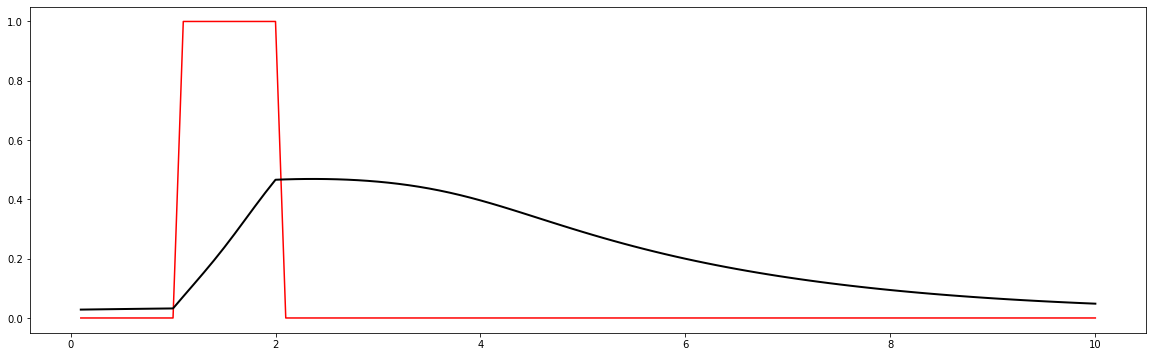

In [244]:
#stimulus
stimulus = np.zeros((1,100))
stimulus[0][10:20] = 1

#plt.plot(stimulus.T)



wc.params["control_term_E"] = stimulus
#wc.params["control_term_I"] = stimulus
wc.run()

plt.figure(figsize = (20, 6))
plt.plot(wc.t, stimulus.T, c = 'r')
plt.plot(wc.t, wc.exc[0].tolist(), c='k', lw = 2)

#0.02788229


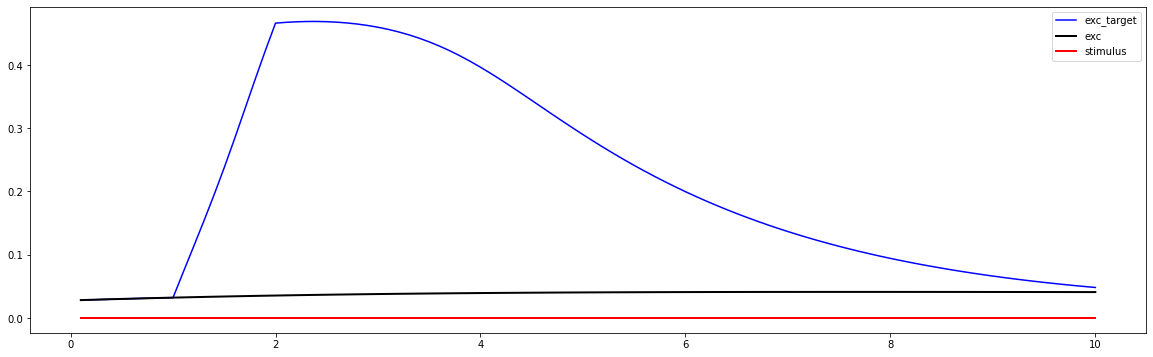

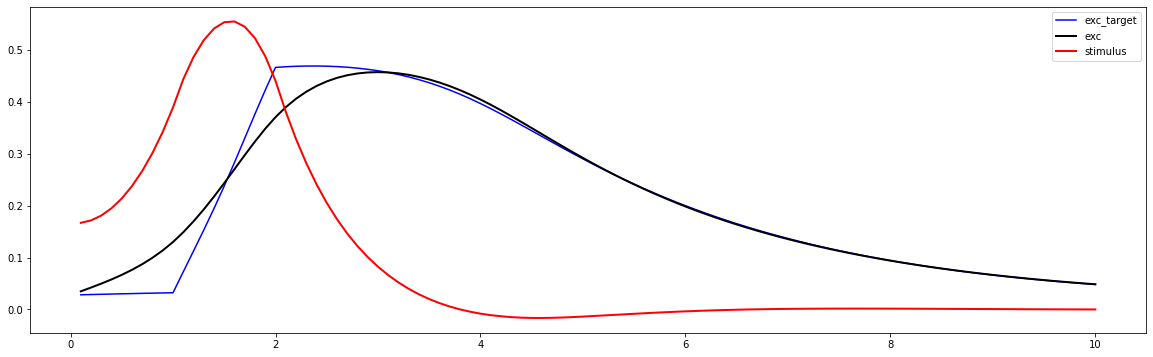

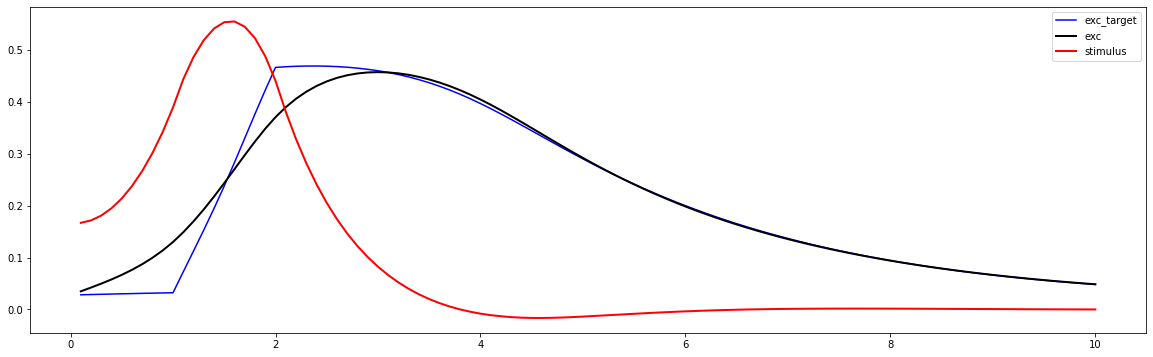

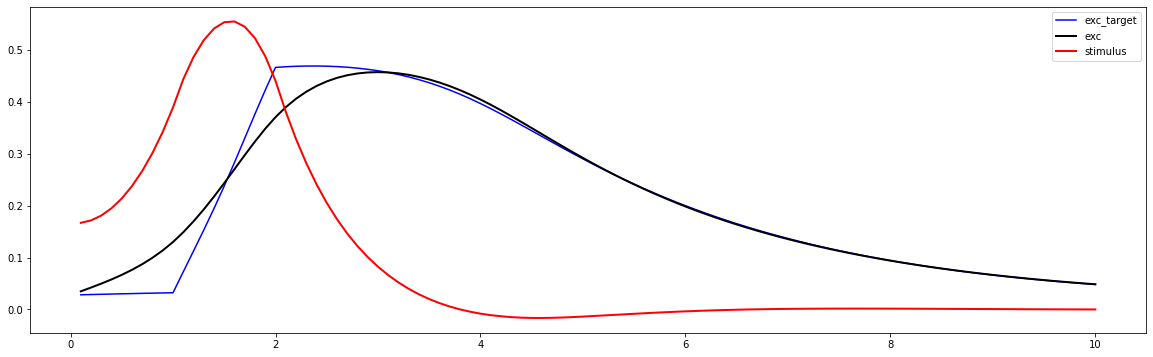

KeyboardInterrupt: 

In [245]:
#wc = WCModel()
#wc.params["control_term"] = s
#wc.params['exc_ext'] = 3.5
#wc.params['inh_ext'] = 3.5
exc=wc.exc[0]
inh = wc.inh[0]

optimal_control(wc, exc,inh, w = [0.01,0.01], a = 0, b = 20, debug = False)
#optimal_control(wc, stimulus, target, target)

# Better example

In [331]:
from neurolib.models.wc import WCModel
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1

wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 3.89


#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1
wc.params['duration'] = 100



1
wc.exc[0] [0.03142162 0.05220678 0.07290822 0.09328619 0.11316311 0.13241587
 0.1509652  0.16876531 0.18579494 0.20205034 0.21753992 0.23228033
 0.24629363 0.2596053  0.27224277 0.28423446 0.29560905 0.30639504
 0.31662039 0.32631234 0.33549722 0.3442004  0.35244621 0.36025799
 0.36765798 0.37466743 0.38130658 0.38759467 0.39355003 0.39919004
 0.40453123 0.40958928 0.4143791  0.41891479 0.42320976 0.4272767
 0.43112766 0.43477404 0.43822668 0.44149582 0.44459118 0.44752196
 0.45029688 0.45292421 0.45541177 0.45776697 0.45999684 0.46210803
 0.46410684 0.46599924 0.46779088 0.4694871  0.47109298 0.47261332
 0.47405266 0.47541531 0.47670534 0.47792662 0.4790828  0.48017733
 0.48121351 0.48219443 0.48312303 0.4840021  0.48483426 0.48562202
 0.48636774 0.48707365 0.48774187 0.48837441 0.48897317 0.48953994
 0.49007643 0.49058426 0.49106494 0.49151992 0.49195057 0.49235819
 0.492744   0.49310917 0.49345479 0.49378191 0.49409151 0.49438453
 0.49466185 0.4949243  0.49517268 0.49540774 0.4956

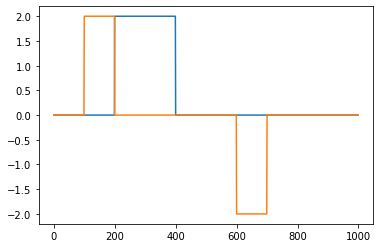

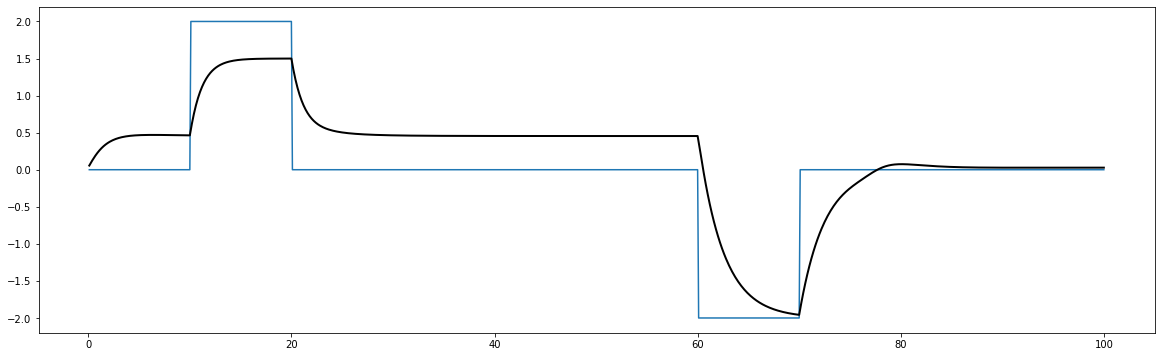

In [322]:
#stimulus
stimulus = np.zeros((1,1000))
stimulus[0][200:400] = 2
stimulus[0][10000:11000] = -1
plt.plot(stimulus.T)

stimulus = np.zeros((1,1000))
stimulus[0][100:200] = 2
stimulus[0][600:700] = -2
plt.plot(stimulus.T)




wc.params["control_term_E"] = stimulus
#wc.params["control_term_I"] = stimulus
wc.run()

plt.figure(figsize = (20, 6))
plt.plot(wc.t, stimulus.T)
plt.plot(wc.t, wc.exc[0].tolist(), c='k', lw = 2)
print(wc.params["a_exc"])
print("wc.exc[0]",wc.inh[-1])
#0.02788229


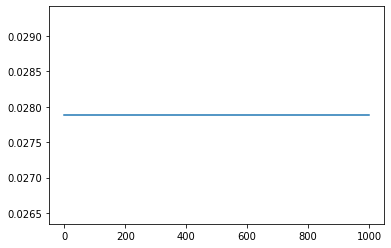

In [332]:
target_low = np.zeros(1000)
target_low[:] = 0.02788229
plt.plot(target_low)

target_low_inh = np.zeros(1000)
target_low_inh[:] = 0.35820838

iteration: 0


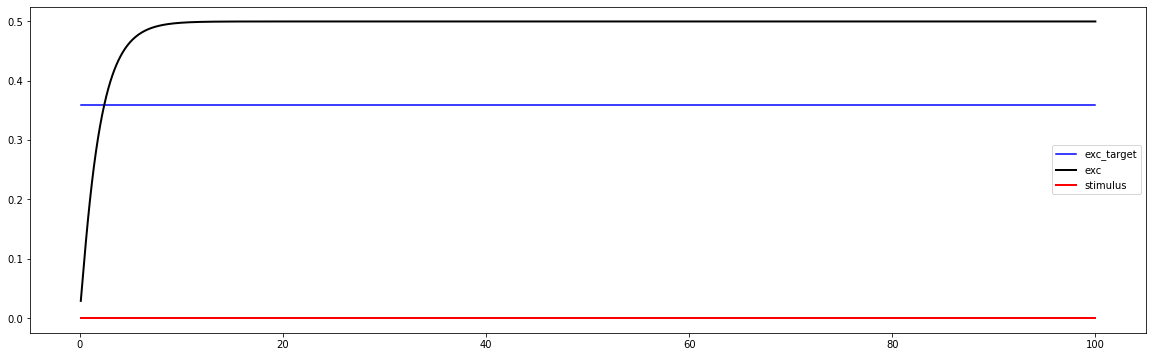

iteration: 20


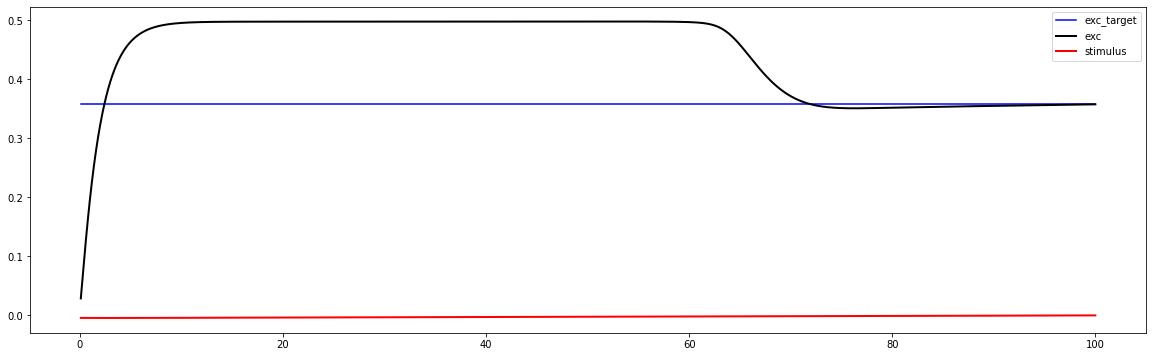

iteration: 40


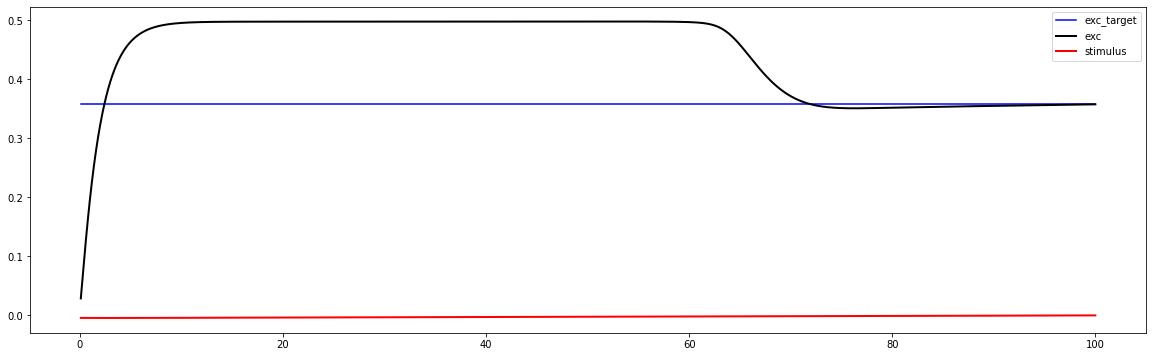

iteration: 60


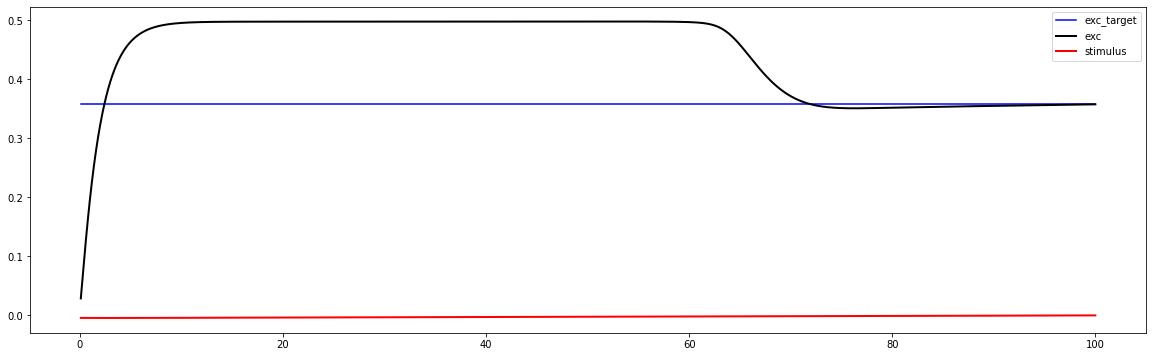

iteration: 80


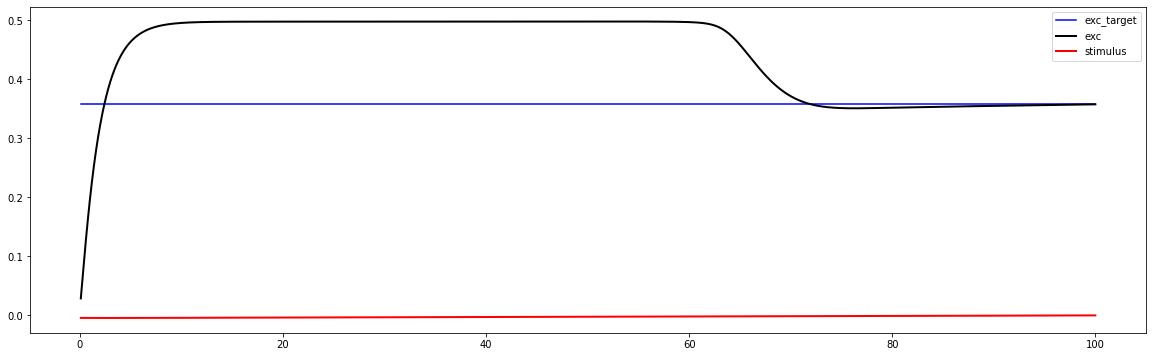

iteration: 100


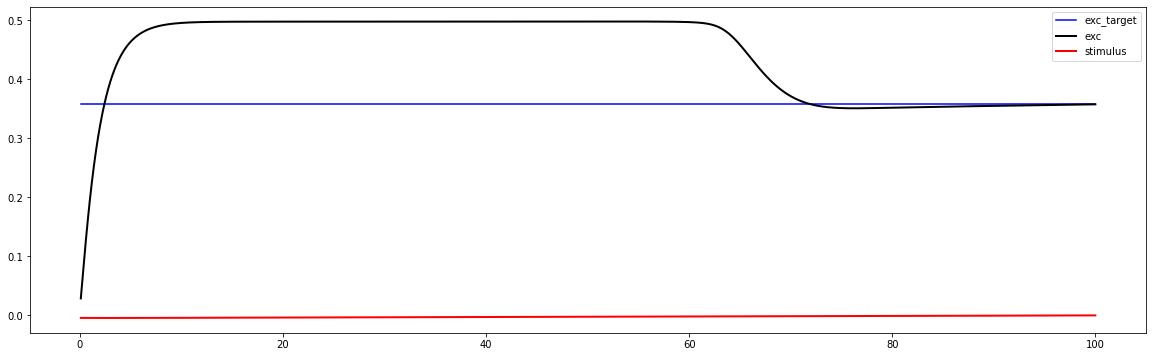

iteration: 120


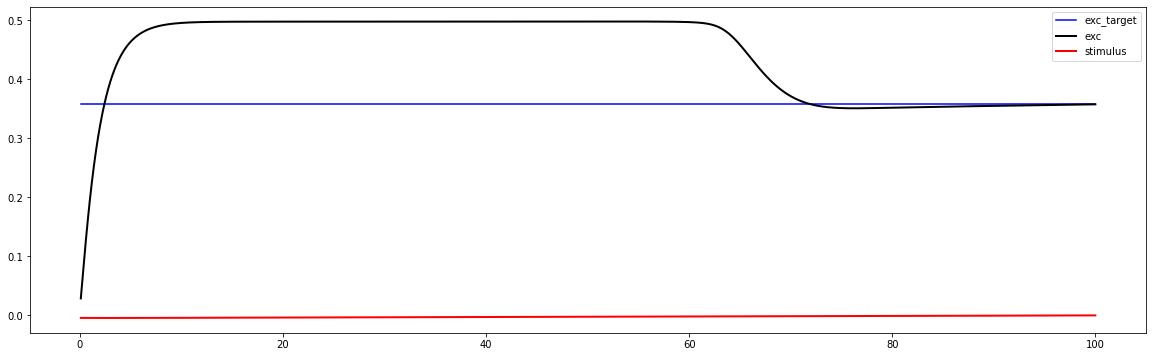

iteration: 140


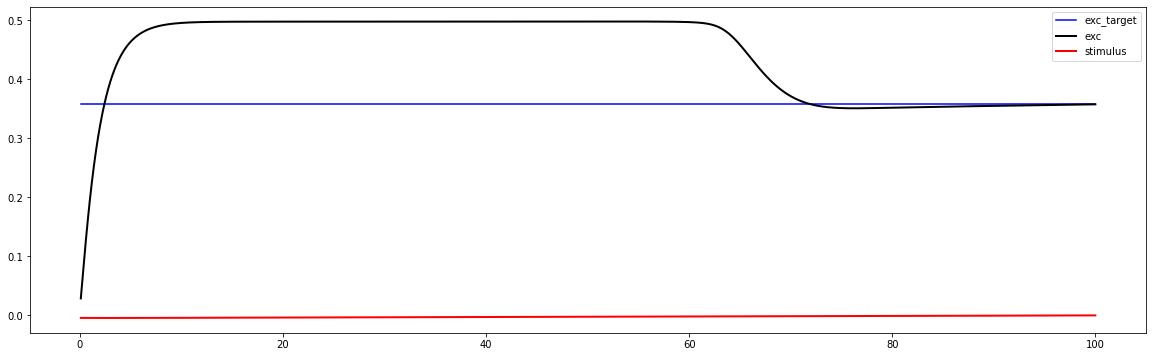

iteration: 160


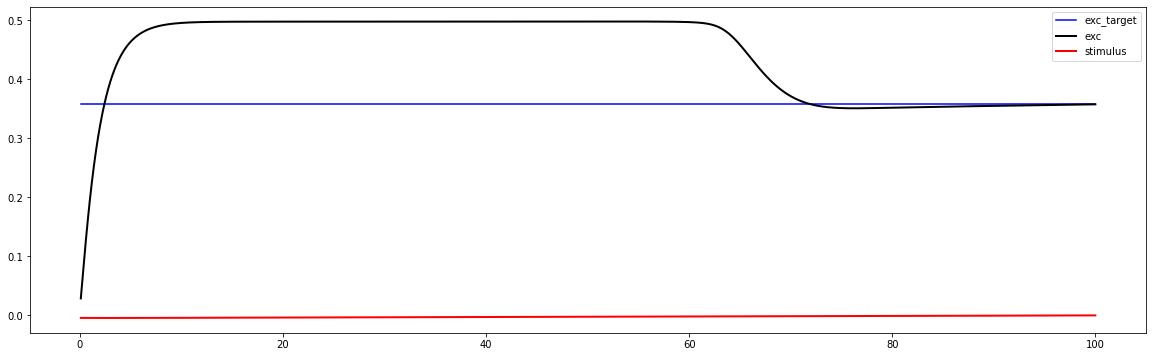

iteration: 180


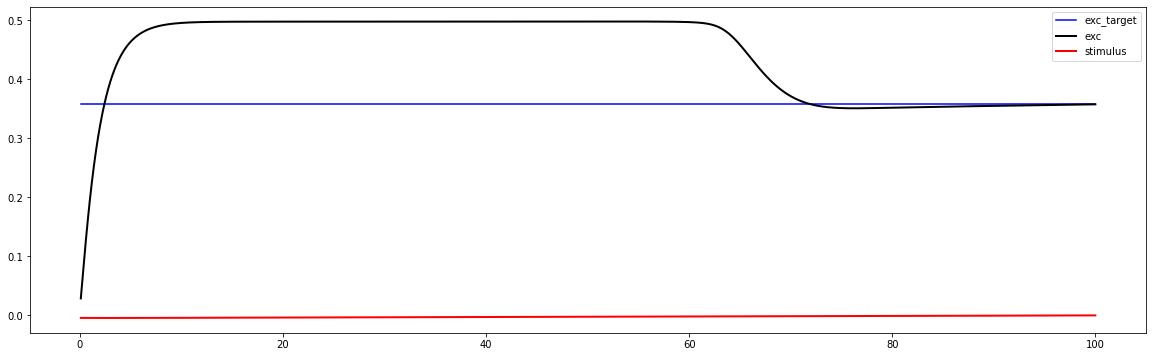

iteration: 200


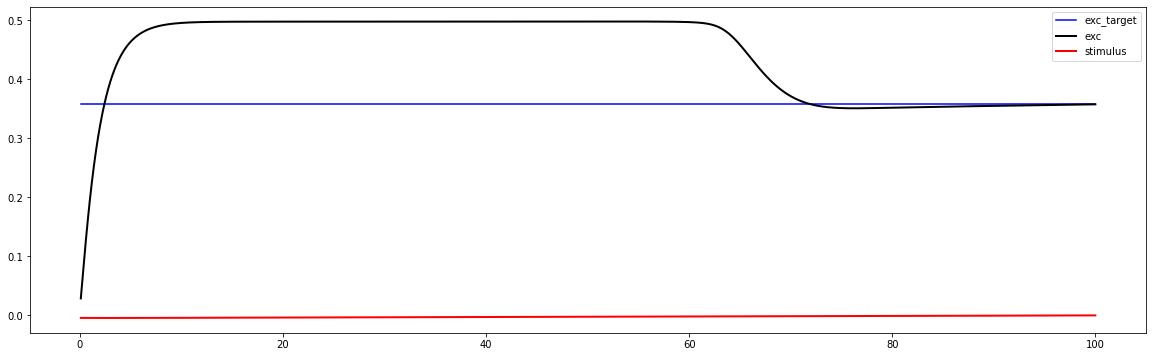

KeyboardInterrupt: 

In [333]:
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1

wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 3.89

wc.params['duration'] = 100


optimal_control(wc, target_low,target_low_inh, n_iter = 500, plot_freq = 20, w = [0.01,0.01], a = 0, b = 800,debug = False)


#optimal_control(wc, stimulus, target, target)

In [34]:
wc.params["control_term"] = stimulus

In [ ]:
#target signal


wc = WCModel()
#wc.params["control_term"] = s
wc.params['exc_ext'] = 0
wc.params['inh_ext'] = 0
wc.run()
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
plt.plot(wc.params["control_term_E"].T)
plt.show()
target_exc = wc.exc


#target = stim.SinusoidalInput(amplitude=0.5, frequency=1).to_model(wc)
#plt.plot(target.T)

#exc_5000 0.013072727462704856
#exc_19999 0.4931700303710192
#inh_5000 0.2985821792704872
#inh_19999 0.49998300736421963


#target
target_exc = np.zeros(20000)
target_exc[1000:19999] = 0.013072727462704856


target_inh = np.zeros(20000)
target_inh[1000:19999] = 0.2985821792704872

## Drafts

In [131]:
wc.params['exc_ext'] = 0
wc.params['inh_ext'] = 0
wc.run()

(1, 20000)


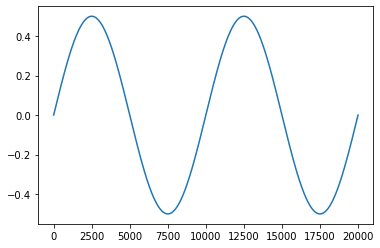

In [156]:
stimulus = stim.SinusoidalInput(amplitude=0.5, frequency=1).to_model(wc)
print(stimulus.shape)
plt.plot(stimulus.T)
wc.params["control_term"] = stimulus

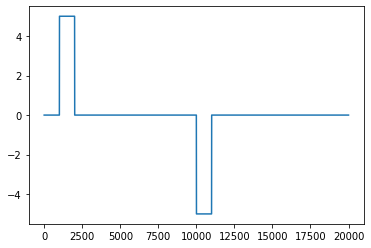

In [196]:
stimulus = np.zeros((20000))
stimulus[1000:2000] = 5
stimulus[10000:11000] = -5
plt.plot(stimulus)

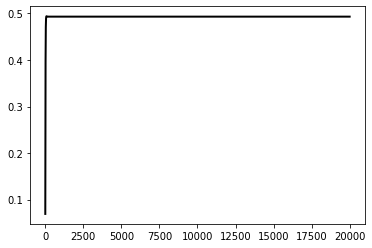

In [182]:
wc = WCModel()
#wc.params["control_term"] = s
wc.params['exc_ext'] = 3.5
wc.params['inh_ext'] = 3.5
wc.run()
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
#plt.plot(s)
plt.show()
target = wc.exc[0]


In [ ]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")

In [ ]:
def dh1_dE():
    return 1

def dh2_dE():
    return 2

def dh1_dI():
    return 3

def dh2_dI():
    return 4

def df_dE():
    return 0

def df_dI():
    return 0

lambd1 = 1
lambd2 = 2
Dxh = np.array([[ dh1_dE(), dh1_dI()], 
                  [dh2_dE(), dh2_dI()]])
lambdas = np.array([lambd1, lambd2])

Dxf = np.array([df_dE(), df_dI()])

tauE = 2
tauI = 8

Dx_doth = np.array([[ -tauE, 0], 
                  [0, -tauI]])
x = np.linalg.solve(Dx_doth, b)

(Dxf - lambdas@Dxh)@np.linalg.inv(Dx_doth)



In [ ]:
exp = stim.SinusoidalInput(amplitude=0.5, frequency=0.5).to_model(wc)
#exp = stim.StepInput(step_size=0.5, start=10, end=80, n=2).to_model(wc)
plt.plot(exp.T)

## Single node simulation

In [ ]:
wc = WCModel()
wc.params['duration'] = 1.0*1000
wc.params['sigma_ou'] = 0.01

wc.run()

In [ ]:
plt.plot(wc.t, wc.exc.T, c='k', lw = 2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")

## Brain network

In [ ]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [ ]:
wc = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

In [ ]:
wc.params['exc_ext'] = 0.65

wc.params['signalV'] = 0
wc.params['duration'] = 20 * 1000 
wc.params['sigma_ou'] = 0.14
wc.params['K_gl'] = 3.15


wc.run(chunkwise=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(func.fc(wc.exc[:, -10000:]))
axs[1].plot(wc.t, wc.exc[::5, :].T, alpha=0.8);
axs[1].set_xlim(0, 200)

In [ ]:
scores = [func.matrix_correlation(func.fc(wc.exc[:, -int(5000/wc.params['dt']):]), fcemp) for fcemp in ds.FCs]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

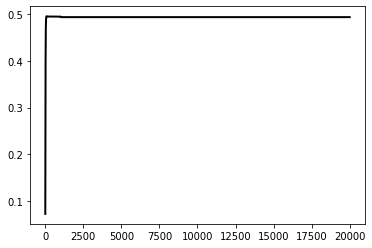

In [18]:
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)